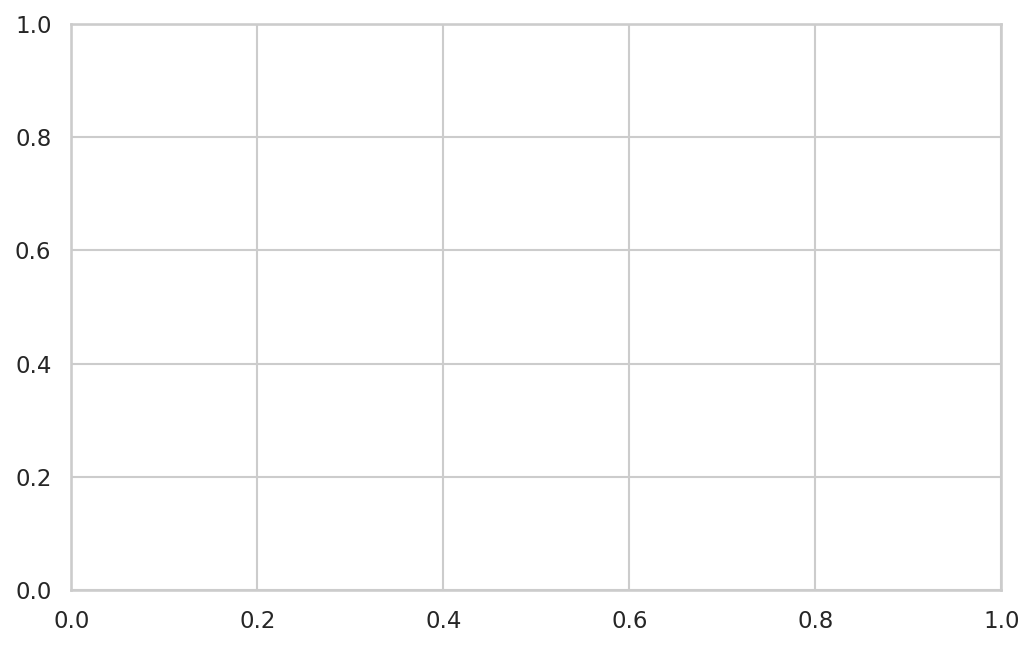

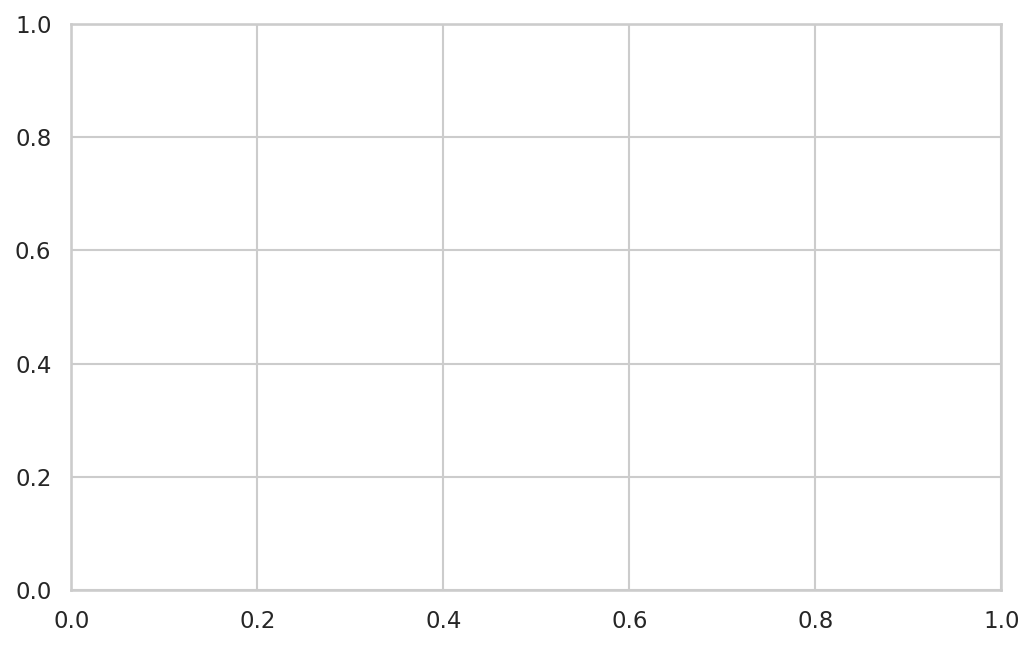

In [82]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), 'LambdaCommBenchmarks'))

def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val == 50000:
            xticks.append("5·10")
        elif val == 5000:
            xticks.append("5·10")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks


experiments = {
    "S3": os.path.join(BASE_PATH, "s3"),
    "Redis": os.path.join(BASE_PATH, "redis"),
    "Direct": os.path.join(BASE_PATH, "nat")
}

results = {}
results_deltas = {}

p2p_experiment_means = {}
p2p_experiment_cis = {}
fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
for experiment_name, exp_base_path in experiments.items():
    p2p_experiment_means[experiment_name] = {}
    p2p_experiment_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out_paper")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out_udt")
    results[experiment_name] = parse_json(var_base_path)
    results_deltas[experiment_name] = calc_deltas(results[experiment_name])

In [114]:


data_path = "." #os.path.join(os.path.pardir, os.path.pardir, 'data', 'invocation_latency_small')

dfs = []
for size in [1, 10, 100, 1000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000]:
    data = pd.read_csv(os.path.join(data_path, 'praas', f'benchmark_{size}'))
    data.set_index('id', drop=True, inplace=True)
    data['size'] = size / 1000
    data['time'] /= 1000.0 * 1000.0
    dfs.append(data)
praas = pd.concat(dfs, axis=0)
praas['type'] = 'praas'
print(praas.groupby(['type','size']).median())

praas['bandwidth'] = praas['size'] / praas['time']
print(praas.groupby(['type','size']).median())

dfs = []
for size in [1, 10, 100, 1000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000]:
    data = pd.read_csv(os.path.join(data_path, 'praas_remote', f'benchmark_{size}'))
    data.set_index('id', drop=True, inplace=True)
    data['size'] = size / 1000
    data['time'] /= 1000.0 * 1000.0
    dfs.append(data)
praas2 = pd.concat(dfs, axis=0)
praas2['type'] = 'praas_warm'
print(praas2.groupby(['type','size']).median())

praas2['bandwidth'] = praas2['size'] / praas2['time']
print(praas2.groupby(['type','size']).median())

praas_data = pd.concat([praas, praas2])
print(praas)

praas.to_csv("praas.csv")

                      time
type  size                
praas 0.001       0.182860
      0.010       0.182923
      0.100       0.235347
      1.000       0.183337
      10.000      0.195551
      50.000      0.238201
      100.000     0.304864
      500.000     0.777080
      1000.000    1.186677
      5000.000    4.907229
      10000.000   9.608911
      20000.000  18.981583
                      time    bandwidth
type  size                             
praas 0.001       0.182860     0.005469
      0.010       0.182923     0.054668
      0.100       0.235347     0.424905
      1.000       0.183337     5.454422
      10.000      0.195551    51.137447
      50.000      0.238201   209.911179
      100.000     0.304864   328.015873
      500.000     0.777080   643.434467
      1000.000    1.186677   842.692083
      5000.000    4.907229  1018.905071
      10000.000   9.608911  1040.700715
      20000.000  18.981583  1053.652875
                            time
type       size              

In [147]:

vals_total = []
for experiment_name, exp_base_path in experiments.items():
    p2p_experiment_means[experiment_name] = {}
    p2p_experiment_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out")
    if experiment_name == "Direct (UDT)":
        var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out_udt")
    res = results[experiment_name]
    deltas = results_deltas[experiment_name]

    
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        series = pd.Series(values).to_frame('time')
        series['size'] = file_size / 1000
        series['type'] = experiment_name
        #print(series)
        vals_total.append(series)
        #upper_ci = np.sort(values)[-2] - val
        #lower_ci = val - np.sort(values)[1]
        #lower_error.append(lower_ci)
        #upper_error.append(upper_ci)
data = pd.concat(vals_total)
data['bandwidth'] = data['size'] / data['time']
print(data)
data = pd.concat([data, praas_data])
print(data)
print('Plot', experiment_name)
#print(vals_total)

          time       size    type   bandwidth
0   221.252930      0.001      S3    0.000005
1    29.593994      0.001      S3    0.000034
2    29.660156      0.001      S3    0.000034
3    34.206055      0.001      S3    0.000029
4    32.687988      0.001      S3    0.000031
..         ...        ...     ...         ...
95   98.578125  20000.000  Direct  202.884768
96   77.043213  20000.000  Direct  259.594574
97   66.411865  20000.000  Direct  301.151006
98  137.156006  20000.000  Direct  145.819353
99   64.099854  20000.000  Direct  312.013194

[3600 rows x 4 columns]
           time       size        type   bandwidth
0    221.252930      0.001          S3    0.000005
1     29.593994      0.001          S3    0.000034
2     29.660156      0.001          S3    0.000034
3     34.206055      0.001          S3    0.000029
4     32.687988      0.001          S3    0.000031
..          ...        ...         ...         ...
195  137.758569  20000.000  praas_warm  145.181531
196  137.181075

           time       size        type   bandwidth
0    221.252930      0.001          S3    0.000005
1     29.593994      0.001          S3    0.000034
2     29.660156      0.001          S3    0.000034
3     34.206055      0.001          S3    0.000029
4     32.687988      0.001          S3    0.000031
..          ...        ...         ...         ...
195  137.758569  20000.000  praas_warm  145.181531
196  137.181075  20000.000  praas_warm  145.792705
197  137.119298  20000.000  praas_warm  145.858390
198  138.633582  20000.000  praas_warm  144.265190
199  137.928730  20000.000  praas_warm  145.002423

[8400 rows x 4 columns]
           time       size        type   bandwidth
0    221.252930      0.001          S3    0.000005
1     29.593994      0.001          S3    0.000034
2     29.660156      0.001          S3    0.000034
3     34.206055      0.001          S3    0.000029
4     32.687988      0.001          S3    0.000031
..          ...        ...         ...         ...
195  1

<Figure size 1200x600 with 0 Axes>

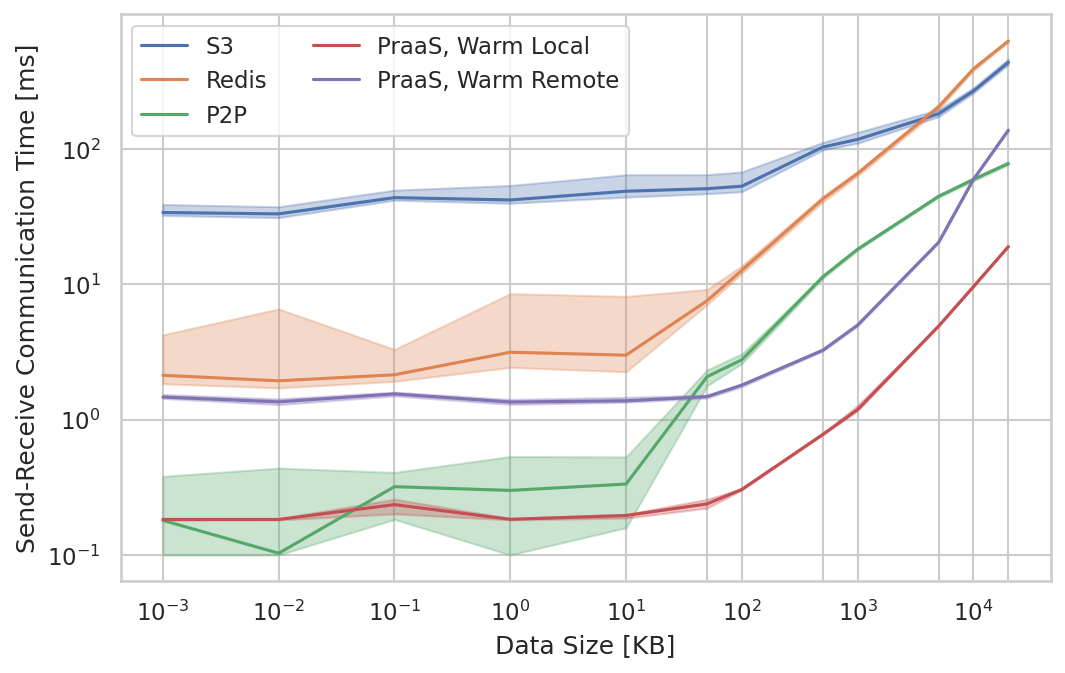

In [156]:
import math
from matplotlib import ticker

def p50_estimator(x):
    #print(x, np.percentile(x,50))
    return np.percentile(x, 50)

plt.clf()

#ax, ax2 = fig.add_subplot(), fig2.add_subplot()
fig = plt.figure(figsize=(8,5))
ax2 = fig.gca()

sns.lineplot(data=data, x='size', y='time', hue='type',  ci=None,estimator=p50_estimator,ax=ax2)
#sns.lineplot(data=praas, x='size', y='bandwidth', ci=95,estimator=p50_estimator,ax=ax)

    #upper_error.append(upper_ci)
sizes = np.array([1, 10, 100, 1000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000])
sizes = sizes / 1000.0
ax2.set_xscale('log')
ax2.set_xlabel("Data Size [KB]")
ax2.set_xticks(sizes)#list(plot_data.keys()))
#plt.setp(ax2.get_xticklabels(), rotation=70, horizontalalignment='right')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#ax2.set_xticklabels(sizes)#format_xticks(plot_data.keys()))
ax2.set_ylabel("Send-Receive Communication Time [ms]")
ax2.set_yscale('log')
    #ax2.set_xscale('log',base=10)
    #print(plot_data)
    #ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    #ax2.errorbar(plot_data.keys(), plot_data.values(), elinewidth=1, capsize=4, label=experiment_name)

    
#sizes = sizes / 1000.0
low = np.zeros(sizes.shape)
high = np.zeros(sizes.shape)


#ax.legend()
#ax.legend(labels=['PraaS, Warm Local', 'S3', 'Redis', 'P2P'])
ax2.legend(labels=['S3', 'Redis', 'P2P', 'PraaS, Warm Local', 'PraaS, Warm Remote'], ncol=2)

col_palette = sns.color_palette()
for idx, data_type in enumerate(['S3','Redis','Direct','praas','praas_warm']):

    i = 0
    print(data)
    data2 = data.loc[(data['type'] == data_type)]
    for row, group in data2.groupby(['size']):
        d = np.sort(group['time'])
        n = len(d)
        low_pos = int(math.floor( (n - 1.96*math.sqrt(n)) / 2))
        high_pos = int(math.ceil(1 +  (n + 1.96*math.sqrt(n)) / 2))
        #print(f'{data_type}, {row}, Non-param 95, {d[low_pos]}, {d[int(n/2)]}, {d[high_pos]}')
        low_pos = int(math.floor( (n - 2.456*math.sqrt(n)) / 2))
        high_pos = int(math.ceil(1 +  (n + 2.456*math.sqrt(n)) / 2))
        #print(f'{data_type}, {row}, Non-param 99, {d[low_pos]}, {d[int(n/2)]}, {d[high_pos]}')
        low[i] = d[low_pos]
        high[i] = d[high_pos]
        i += 1

    indices = {
        0:0,
        1:1,
        2:2,
        3:3,
        4:4
    }
    #low -= 0.5
    #high += 0.5
    ax2.fill_between(sizes, low, high, alpha=.3, color=col_palette[indices[idx]])

fig.savefig("global_memory_latency.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

           time       size        type   bandwidth
0    221.252930      0.001          S3    0.000005
1     29.593994      0.001          S3    0.000034
2     29.660156      0.001          S3    0.000034
3     34.206055      0.001          S3    0.000029
4     32.687988      0.001          S3    0.000031
..          ...        ...         ...         ...
195  137.758569  20000.000  praas_warm  145.181531
196  137.181075  20000.000  praas_warm  145.792705
197  137.119298  20000.000  praas_warm  145.858390
198  138.633582  20000.000  praas_warm  144.265190
199  137.928730  20000.000  praas_warm  145.002423

[8400 rows x 4 columns]
           time       size        type   bandwidth
0    221.252930      0.001          S3    0.000005
1     29.593994      0.001          S3    0.000034
2     29.660156      0.001          S3    0.000034
3     34.206055      0.001          S3    0.000029
4     32.687988      0.001          S3    0.000031
..          ...        ...         ...         ...
195  1

<Figure size 1200x600 with 0 Axes>

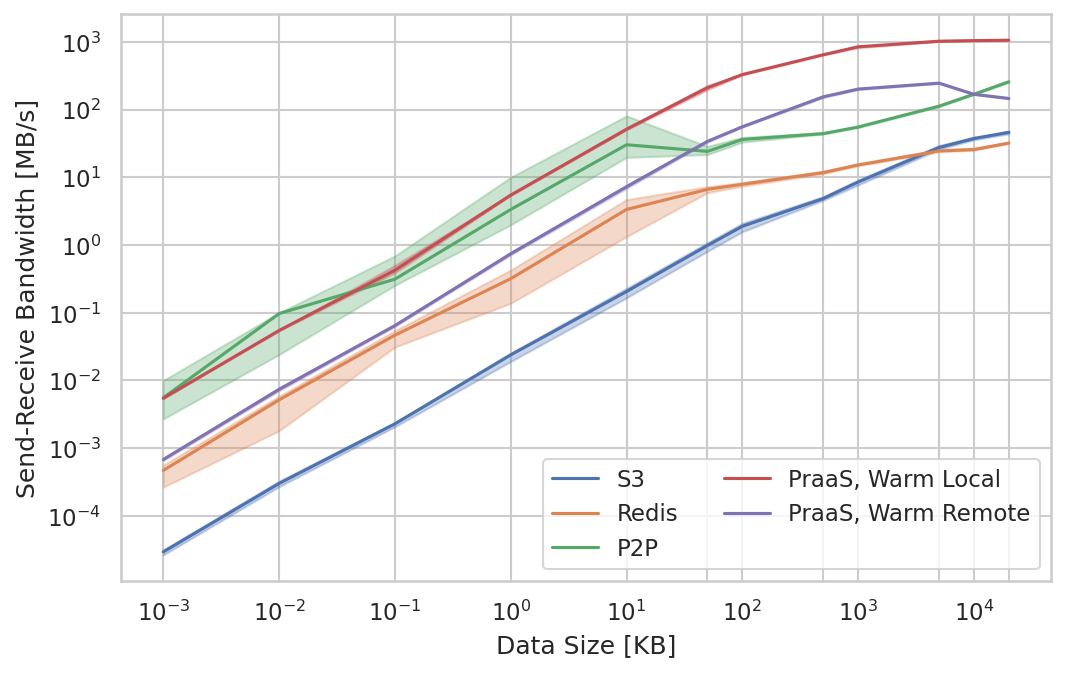

In [154]:
import math
from matplotlib import ticker

def p50_estimator(x):
    #print(x, np.percentile(x,50))
    return np.percentile(x, 50)

plt.clf()
p2p_experiment_means = {}
p2p_experiment_cis = {}
#fig, fig2 = plt.figure(figsize=(8,5)), plt.figure(figsize=(8,5))

#ax, ax2 = fig.add_subplot(), fig2.add_subplot()
fig = plt.figure(figsize=(8,5))
ax2 = fig.gca()
sns.lineplot(data=data, x='size', y='bandwidth', hue='type',  ci=None,estimator=p50_estimator,ax=ax2)
#sns.lineplot(data=praas, x='size', y='bandwidth', ci=95,estimator=p50_estimator,ax=ax)

    #upper_error.append(upper_ci)
sizes = np.array([1, 10, 100, 1000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000])
sizes = sizes / 1000.0
ax2.set_xscale('log')
ax2.set_xlabel("Data Size [KB]")
ax2.set_xticks(sizes)#list(plot_data.keys()))
#plt.setp(ax2.get_xticklabels(), rotation=70, horizontalalignment='right')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#ax2.set_xticklabels(sizes)#format_xticks(plot_data.keys()))
ax2.set_ylabel("Send-Receive Bandwidth [MB/s]")
ax2.set_yscale('log')
    #ax2.set_xscale('log',base=10)
    #print(plot_data)
    #ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)
    #ax2.errorbar(plot_data.keys(), plot_data.values(), elinewidth=1, capsize=4, label=experiment_name)

    
#sizes = sizes / 1000.0
low = np.zeros(sizes.shape)
high = np.zeros(sizes.shape)


#ax.legend()
#ax.legend(labels=['PraaS, Warm Local', 'S3', 'Redis', 'P2P'])
ax2.legend(labels=['S3', 'Redis', 'P2P', 'PraaS, Warm Local', 'PraaS, Warm Remote'], ncol=2)

col_palette = sns.color_palette()
for idx, data_type in enumerate(['S3','Redis','Direct','praas','praas_warm']):

    i = 0
    print(data)
    data2 = data.loc[(data['type'] == data_type)]
    for row, group in data2.groupby(['size']):
        d = np.sort(group['bandwidth'])
        n = len(d)
        low_pos = int(math.floor( (n - 1.96*math.sqrt(n)) / 2))
        high_pos = int(math.ceil(1 +  (n + 1.96*math.sqrt(n)) / 2))
        #print(f'{data_type}, {row}, Non-param 95, {d[low_pos]}, {d[int(n/2)]}, {d[high_pos]}')
        low_pos = int(math.floor( (n - 2.456*math.sqrt(n)) / 2))
        high_pos = int(math.ceil(1 +  (n + 2.456*math.sqrt(n)) / 2))
        #print(f'{data_type}, {row}, Non-param 99, {d[low_pos]}, {d[int(n/2)]}, {d[high_pos]}')
        low[i] = d[low_pos]
        high[i] = d[high_pos]
        i += 1

    indices = {
        0:0,
        1:1,
        2:2,
        3:3,
        4:4
    }
    #low -= 0.5
    #high += 0.5
    ax2.fill_between(sizes, low, high, alpha=.3, color=col_palette[indices[idx]])

fig.savefig("global_memory_bandwidth.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)